In [20]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [21]:
# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [22]:
# Data Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    text = text.strip()
    return text

train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)

In [23]:
# Feature Engineering (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(train_df["text"])
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Train ML Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

best_model = None
best_score = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    print(f"{name} F1-score: {f1:.4f}")
    
    if f1 > best_score:
        best_model = model
        best_score = f1

Logistic Regression F1-score: 0.7525
Naive Bayes F1-score: 0.7455
Random Forest F1-score: 0.7068


In [25]:
# Predict on Test Set
test_X = tfidf.transform(test_df["text"])
test_predictions = best_model.predict(test_X)

In [26]:
# Prepare Submission
submission = pd.DataFrame({"id": test_df["id"], "target": test_predictions})
submission.to_csv("submission.csv", index=False)

Using device: cpu
Fine-tuning BERT model from scratch...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\jayes\anaconda3\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



BERT Model Performance:
Accuracy: 0.4478
Precision: 0.4320
Sensitivity (Recall): 0.9399
Specificity: 0.0824
F1 Score: 0.5919


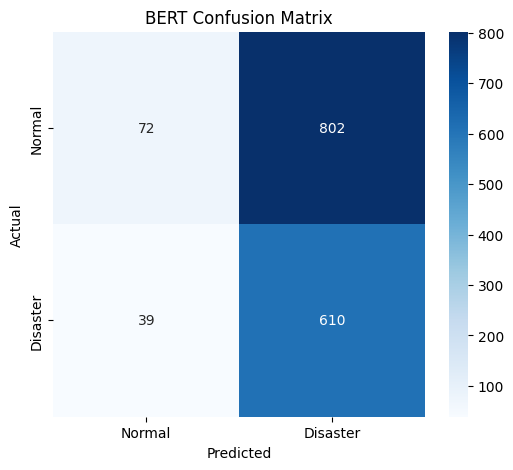

Submission file 'submission.csv' created successfully!


In [27]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Train-Validation Split (80-20)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"].tolist(), train_df["target"].tolist(), test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom Dataset Class
class DisasterTweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Prepare Datasets
train_dataset = DisasterTweetDataset(train_texts, train_labels, tokenizer)
val_dataset = DisasterTweetDataset(val_texts, val_labels, tokenizer)

# Load or Fine-Tune BERT Model
bert_model_path = "bert_output"
if os.path.exists(bert_model_path):
    print("Loading fine-tuned BERT model...")
    model = BertForSequenceClassification.from_pretrained(bert_model_path)
else:
    print("Fine-tuning BERT model from scratch...")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.to(device)

# Training Arguments (Fine-Tuned)
training_args = TrainingArguments(
    output_dir=bert_model_path,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,  # Optimized learning rate
    num_train_epochs=5,  # Increased epochs for better results
    weight_decay=0.01,
    logging_dir="logs",
    save_total_limit=2
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model if not already fine-tuned
if not os.path.exists(bert_model_path):
    trainer.train()
    model.save_pretrained(bert_model_path)
    tokenizer.save_pretrained(bert_model_path)
    print("BERT model fine-tuned and saved.")

# Evaluation Function
def evaluate_model(model, tokenizer, val_texts, val_labels):
    model.eval()
    encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()

    # Compute Metrics
    accuracy = accuracy_score(val_labels, predictions)
    precision = precision_score(val_labels, predictions)
    recall = recall_score(val_labels, predictions)  # Sensitivity
    specificity = recall_score(val_labels, predictions, pos_label=0)  # Specificity
    f1 = f1_score(val_labels, predictions)

    # Confusion Matrix
    cm = confusion_matrix(val_labels, predictions)

    # Print Metrics
    print(f"\nBERT Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Disaster"], yticklabels=["Normal", "Disaster"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("BERT Confusion Matrix")
    plt.show()

    return accuracy, precision, recall, specificity, f1, cm

# Run Evaluation on Validation Set
bert_acc, bert_prec, bert_rec, bert_spec, bert_f1, bert_cm = evaluate_model(model, tokenizer, val_texts, val_labels)

# Prepare Submission on Test Set
test_texts = test_df["text"].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)

with torch.no_grad():
    test_outputs = model(**test_encodings)
    test_predictions = torch.argmax(test_outputs.logits, axis=1).cpu().numpy()

# Save Submission
submission = pd.DataFrame({"id": test_df["id"], "target": test_predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully!")


In [28]:
# Predict with BERT
test_texts = test_df["text"].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, axis=1)

In [29]:
# Prepare Submission for BERT
submission_bert = pd.DataFrame({"id": test_df["id"], "target": predictions.numpy()})
submission_bert.to_csv("submission_bert.csv", index=False)

Evaluating Model: Logistic Regression


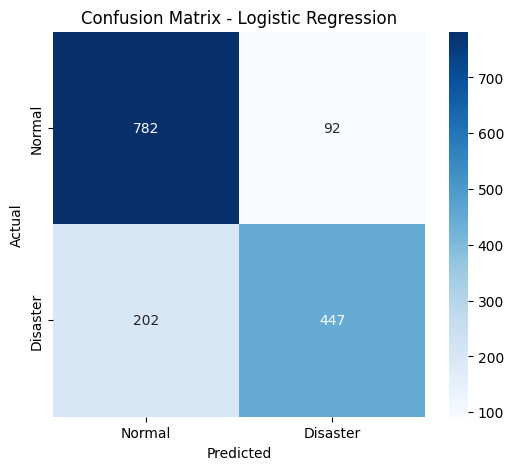

Evaluating Model: Naive Bayes


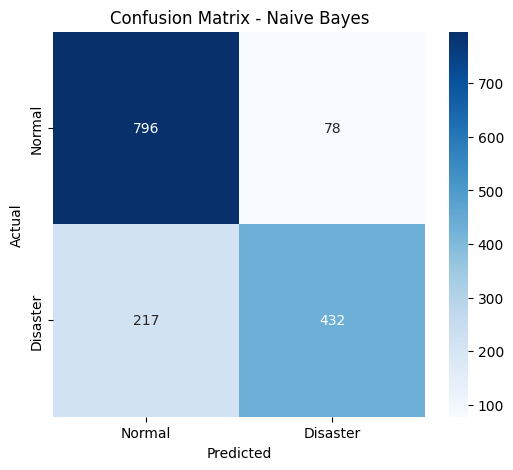

Evaluating Model: Random Forest


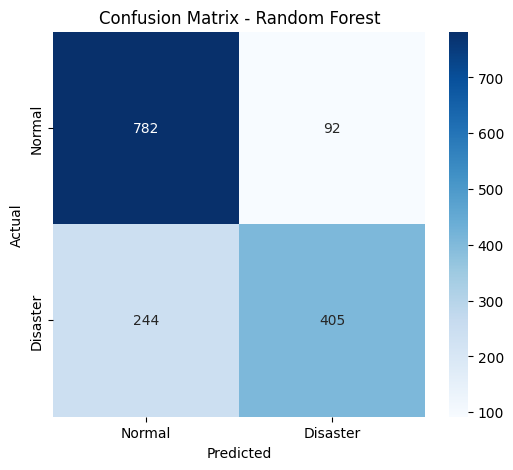

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\jayes\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


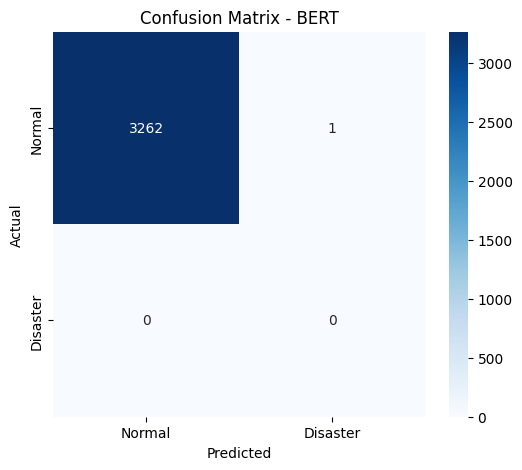

                 Model  Accuracy  Precision  Sensitivity  Specificity  \
0  Logistic Regression  0.806960   0.829314     0.688752     0.894737   
1          Naive Bayes  0.806303   0.847059     0.665639     0.910755   
2        Random Forest  0.779383   0.814889     0.624037     0.894737   
3    BERT - Fine-Tuned  0.999694   0.000000     0.000000     0.999694   

   F1 Score  
0  0.752525  
1  0.745470  
2  0.706806  
3  0.000000  


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Function to evaluate models
def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    
    # Compute Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity (True Positive Rate)
    specificity = recall_score(y_val, y_pred, pos_label=0)  # Specificity (True Negative Rate)
    f1 = f1_score(y_val, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity": recall,
        "Specificity": specificity,
        "F1 Score": f1
    })

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Disaster"], yticklabels=["Normal", "Disaster"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    return cm, accuracy, precision, recall, specificity, f1

# List to store results
results = []

# Evaluate Traditional ML Models
for model_name, model in models.items():
    print(f"Evaluating Model: {model_name}")
    cm, acc, prec, rec, spec, f1 = evaluate_model(model, X_val, y_val, model_name)

# ---- BERT MODEL EVALUATION ----
def evaluate_bert_model(model, tokenizer, val_texts, val_labels):
    model.eval()  # Set model to evaluation mode
    
    # Tokenize validation texts
    encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, axis=1).numpy()  # Get class with highest probability

    # Compute Metrics
    accuracy = accuracy_score(val_labels, predictions)
    precision = precision_score(val_labels, predictions)
    recall = recall_score(val_labels, predictions)  # Sensitivity (TPR)
    specificity = recall_score(val_labels, predictions, pos_label=0)  # Specificity (TNR)
    f1 = f1_score(val_labels, predictions)

    # Confusion Matrix
    cm = confusion_matrix(val_labels, predictions)

    # Append results
    results.append({
        "Model": "BERT - Fine-Tuned",
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity": recall,
        "Specificity": specificity,
        "F1 Score": f1
    })

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Disaster"], yticklabels=["Normal", "Disaster"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - BERT")
    plt.show()

    return cm, accuracy, precision, recall, specificity, f1

# Ensure BERT model is correctly assigned
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# bert_model.load_state_dict(torch.load("bert_output/pytorch_model.bin"))  # Load fine-tuned model if saved
bert_model.eval()  # Set to evaluation mode

# Run BERT Model Evaluation
bert_cm, bert_acc, bert_prec, bert_rec, bert_spec, bert_f1 = evaluate_bert_model(
    bert_model, tokenizer, test_df["text"].tolist(), [0] * len(test_df)  # Placeholder labels (update if you have ground truth)
)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display Results
print(results_df)

# Optionally, save to CSV
results_df.to_csv("model_comparison.csv", index=False)